In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from pathlib import Path
from ligo.skymap.io.fits import read_sky_map
from concurrent.futures import as_completed, ProcessPoolExecutor, ThreadPoolExecutor
#from mdc_analytics.crossmatch.gracedb import _process_skymap_offline, parallelize, CROSSMATCH_KEYS
from astropy.coordinates import SkyCoord
from astropy import units as u
from tqdm.notebook import tqdm
import ligo.skymap.plot
from functools import partial
from ligo.gracedb.rest import GraceDb
from io import BytesIO
from igwn_ligolw import lsctables
from igwn_ligolw import utils as ligolw_utils
from ligo.skymap.io import events
from gwpy.time import tconvert
from tqdm.auto import tqdm
import ligo.skymap.plot

/home/ethan.marx/projects/mdc-analytics/.venv/lib/python3.12/site-packages/igwn_ligolw/lsctables.py:57: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
data = pd.read_hdf("/home/ethan.marx/projects/mdc_analytics/output/aframe-playground-llpic/all_pipelines/events.hdf5")

## Skymap Plots

### Searched Area

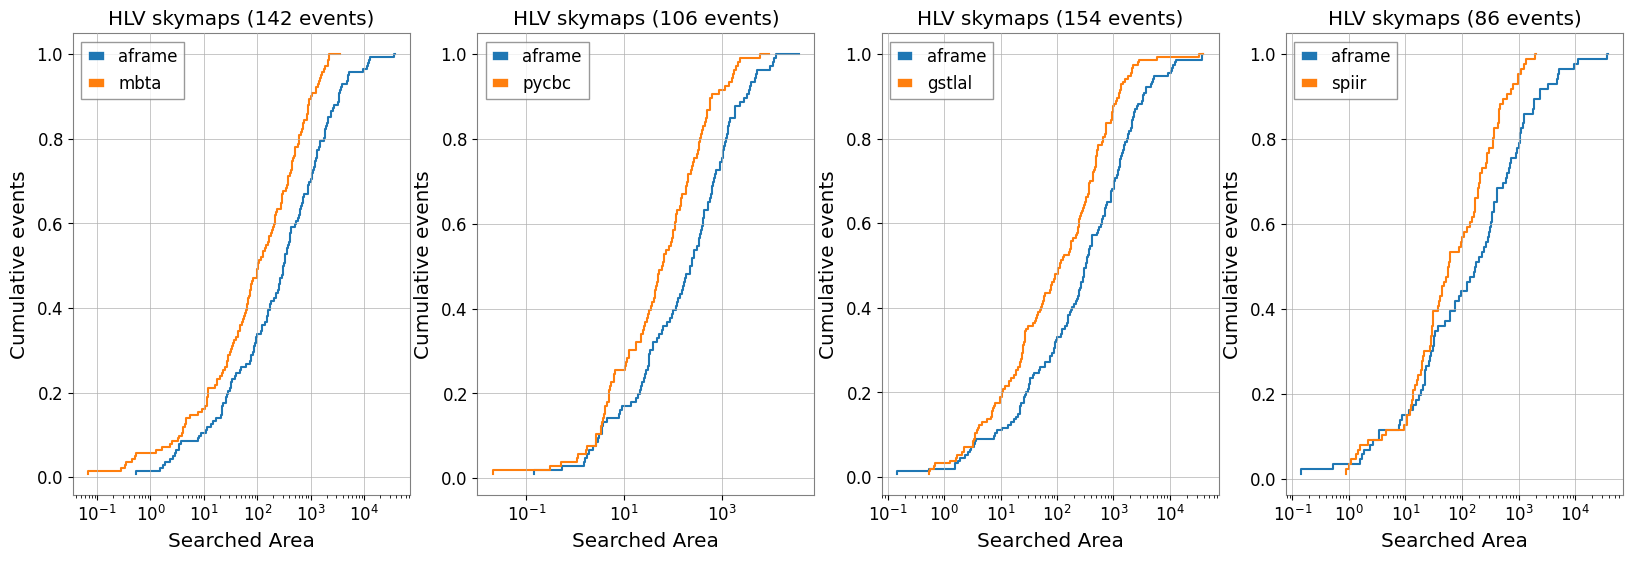

In [3]:
pipelines = ["mbta", "pycbc", "gstlal", "spiir"] 
ifo_configs = ["HLV"]
fig, ax = plt.subplots(len(ifo_configs), len(pipelines), figsize = (20,  6 * len(ifo_configs)))

while ax.ndim < 2:
    ax = ax[None]

for row, ifo_config in zip(ax, ifo_configs):
    for ax, pipeline in zip(row, pipelines):

        pipeline_key = f"{pipeline}_searched_area_{ifo_config}"
        mask = np.ones(len(data), dtype=bool)
        try: 
            mask = getattr(data, pipeline_key).notnull()
        except AttributeError:
            ax.set_axis_off()
            continue
        
        mask &= getattr(data, f"aframe_searched_area_{ifo_config}").notnull()
        counts = np.arange(1, sum(mask) + 1) / sum(mask) 

        ax.set_title(f"{ifo_config} skymaps ({sum(mask)} events)")
        ax.step(np.sort(getattr(data[mask], f"aframe_searched_area_{ifo_config}")), counts, label="aframe")
        ax.step(np.sort(getattr(data[mask], pipeline_key)), counts, label=pipeline)
        ax.set_xscale("log")
        ax.set_xlabel("Searched Area")
        ax.set_ylabel("Cumulative events")
        ax.legend()

### Searched Volume

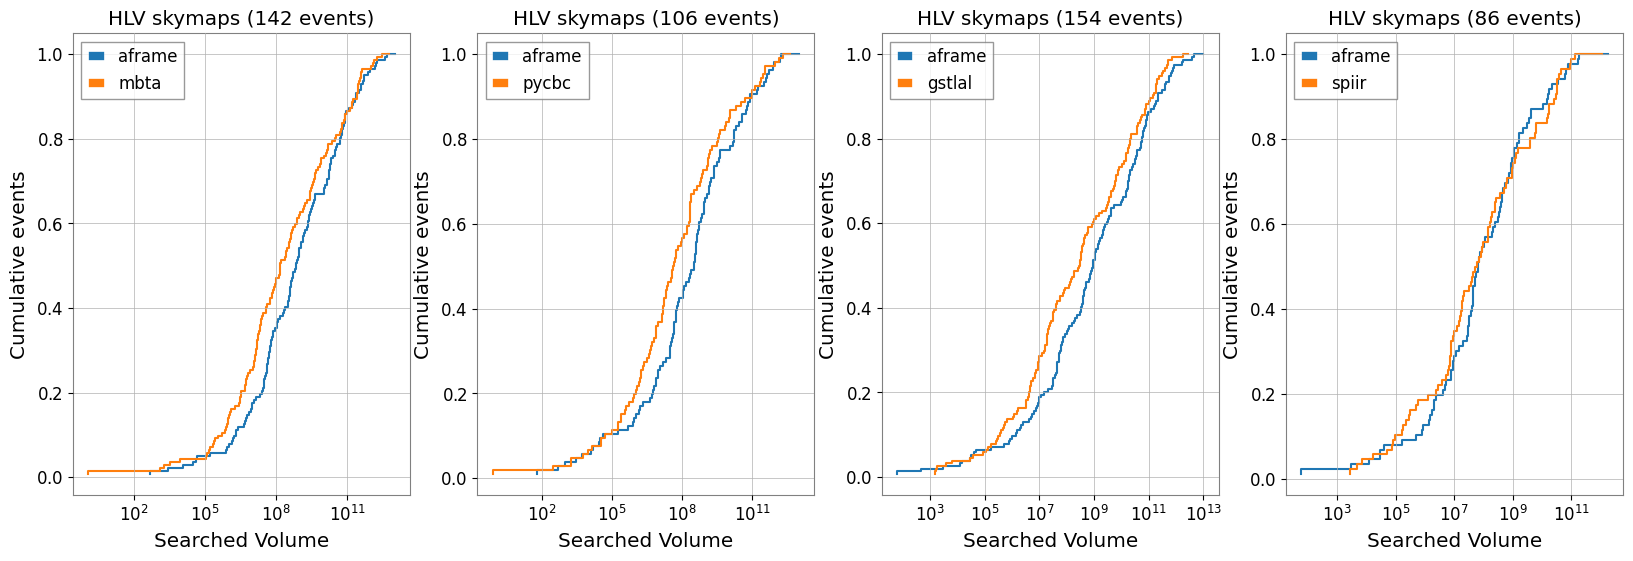

<Figure size 700x700 with 0 Axes>

In [4]:
pipelines = ["mbta", "pycbc", "gstlal", "spiir"] 
ifo_configs = ["HLV"]
fig, ax = plt.subplots(len(ifo_configs), len(pipelines), figsize = (20,  6 * len(ifo_configs)))

while ax.ndim < 2:
    ax = ax[None]

for row, ifo_config in zip(ax, ifo_configs):
    for ax, pipeline in zip(row, pipelines):

        pipeline_key = f"{pipeline}_searched_vol_{ifo_config}"
        mask = np.ones(len(data), dtype=bool)
        try: 
            mask = getattr(data, pipeline_key).notnull()
        except AttributeError:
            ax.set_axis_off()
            continue
        
        mask &= getattr(data, f"aframe_searched_vol_{ifo_config}").notnull()
        counts = np.arange(1, sum(mask) + 1) / sum(mask) 

        ax.set_title(f"{ifo_config} skymaps ({sum(mask)} events)")
        ax.step(np.sort(getattr(data[mask], f"aframe_searched_vol_{ifo_config}")), counts, label="aframe")
        ax.step(np.sort(getattr(data[mask], pipeline_key)), counts, label=pipeline)
        ax.set_xscale("log")
        ax.set_xlabel("Searched Volume")
        ax.set_ylabel("Cumulative events")
        ax.legend()
ig = plt.figure(figsize=(7, 7))


### Skymap Consistency

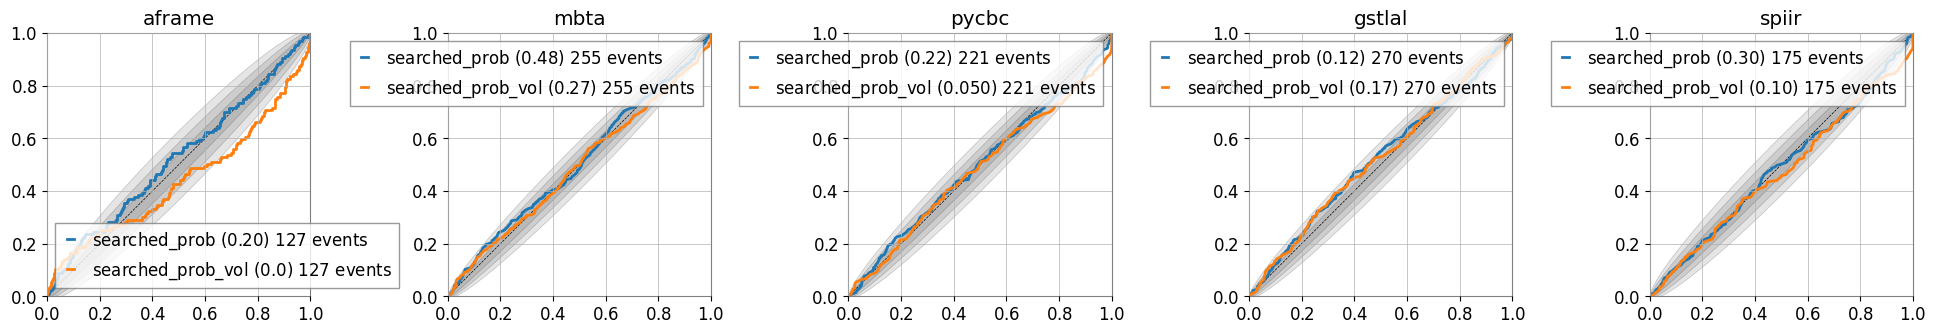

In [5]:
pipelines = ["aframe", "mbta", "pycbc", "gstlal", "spiir"] 
fig = plt.figure(figsize=(20, 10))
for i, pipeline in enumerate(pipelines):
    ax = fig.add_subplot(1, len(pipelines), i + 1, projection="pp_plot")
    for j, attr in enumerate(["searched_prob", "searched_prob_vol"]):
        
        pipeline_key = f"{pipeline}_{attr}_{ifo_config}"
       
        mask = np.ones(len(data), dtype=bool)
        mask &= getattr(data, pipeline_key).notnull()
        mask &= data.snr_net > 10
        number_of_samples = sum(mask) 

        if j == 0:
            alphas = [0.68, 0.95, 0.997]
            for alpha in alphas:
                ax.add_confidence_band(
                    number_of_samples,
                    alpha=alpha,
                    color=(0, 0, 0, 0.1),
                    edgecolor=(0, 0, 0, 0.2),
                    annotate=False,
                )
            ax.add_diagonal()
        
        counts = np.arange(1, number_of_samples + 1) / sum(mask) 
        p = scipy.stats.kstest(data[mask][pipeline_key], "uniform").pvalue
        ax.set_title(pipeline)
        ax.add_series(
            data[mask][pipeline_key], 
            label=attr 
            + r"$~({0:#.2g})$ ".format(round(p, 2))
            + str(number_of_samples)
            + " events",
            linewidth=2,
        )
        ax.legend()
plt.tight_layout()

## Scatter Plots

### Chirp Mass Recovery

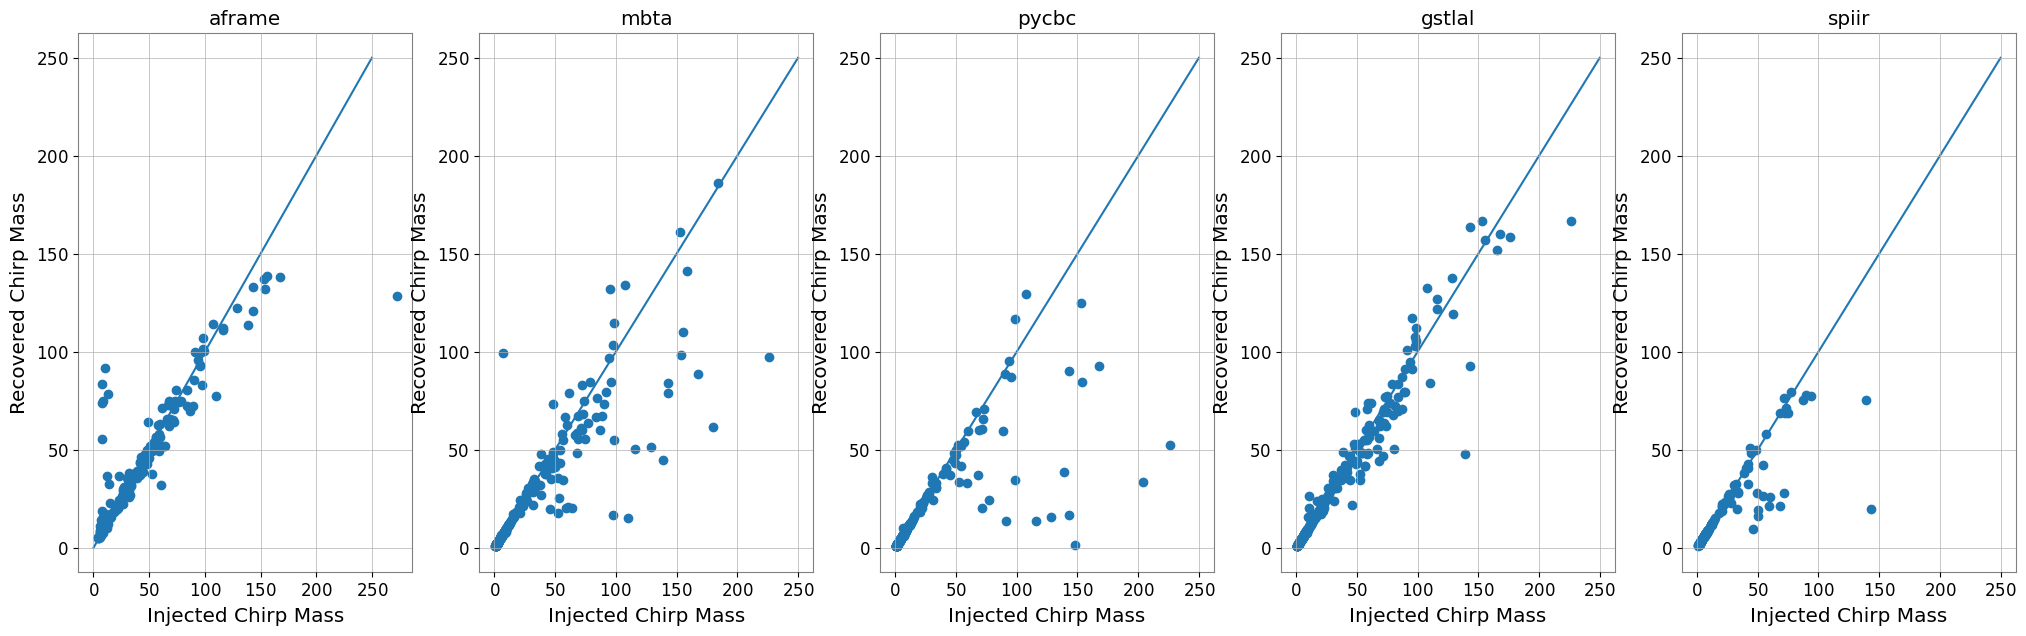

In [6]:
fig, axs = plt.subplots(1, len(pipelines), figsize = (25, 7))
for ax, pipeline in zip(axs, pipelines):
    found = data[f"{pipeline}_graceid"].values != "" 
    found = data[found]
    ax.scatter(found["chirp_mass"], found[f"{pipeline}_chirp_mass"])
    ax.set_xlabel("Injected Chirp Mass")
    ax.set_ylabel("Recovered Chirp Mass")
    ax.plot([0, 250], [0, 250])
    ax.set_title(pipeline)

### Distance Recovery

Text(0.5, 1.0, 'aframe')

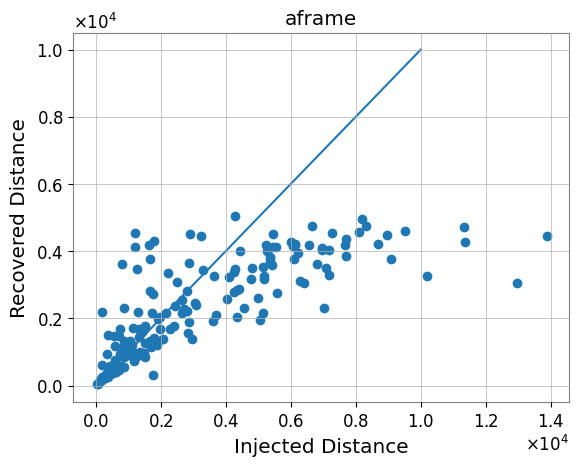

In [ ]:
fig = plt.figure()

pipeline = "aframe"
found = data[f"{pipeline}_graceid"].values != "" 
found = data[found]
plt.scatter(found["luminosity_distance"], found[f"{pipeline}_luminosity_distance"])
plt.xlabel("Injected Distance")
plt.ylabel("Recovered Distance")
plt.plot([0, 1e4], [0, 1e4])
plt.title(pipeline)